# Analysis of Budyko Data from VIC, Subsetted by Ecoregion

### Theodore Barnhart | Created: 20150306 | Updated: 20150309

Script to take the Budyko relevent data mined from Ben L.'s VIC simulations and plot it in Budyko space. 

### Foreword

This notebook goes through some analyses of the Ben's VIC simulation with the goal of elucidating a process control on the streamflow anomaly pattern shown by Berghuijs and others. 

***Generally, figures are followed by a explanative caption. You can ingnor the code.*** 

### Front Matter

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy import stats

In [3]:
data = pd.read_hdf('./budyko_working_er_sm2.hdf','df')

In [4]:
# define a function for computing the EI from a given DI
def budyko(DI):
    return np.sqrt(DI*np.tanh(1/DI)*(1-np.exp(-DI)))

In [5]:
data['PETpenvic_P'] = data['PETpenmanvic']/data['P'] # compute the dryness index

In [6]:
data['ET_P'] = data['ET']/data['P'] # compute the evaporative index

## Plot the Budyko Curve

In [7]:
DI = np.arange(0,50.001,0.001) # make a range to compute the budyko curve over

In [8]:
EI = budyko(DI) # compute the Budyko Curve

## Compute Budyko anomaly

In [9]:
data['pred_EI'] = data['PETpenvic_P'].apply(budyko) # compute the predicted evaportative index for each cell given its aridity

In [10]:
data['Q_P'] = 1.-data['ET_P'] # compute actual runoff for each cell 

In [11]:
data['Qpred_P'] = 1.-data['pred_EI'] # compute predicted runoff for each cell

In [12]:
data['Qanom_P'] = data['Q_P']-data['Qpred_P'] # compute the anomoly (actual - predicted)

In [13]:
data['Q'] = data.Q_P*data.P # compute Q not normalized by P

In [14]:
data['Qanom'] = data.Qanom_P*data.P

In [15]:
regions = ['Cascades','Sierra','Northern Rockies',
           'Wasatch and Uintas','Southern Rockies']

### Fit a model to the streamflow anaomaly

In [16]:
X = data.Sf # pull out the independant variable
y = data.Qanom_P # pull out the dependant variable

slope, intercept, gr_value, gp_value, std_err = stats.linregress(X,y) # fit the model

Sfg = np.arange(0,1.001,.001) # generate a smooth snow fraction domain

modg = Sfg*slope+intercept # generate predicted values

In [17]:
mods = []
rvals = []
pvals = []
slopes = []
intercepts = []
Sfs = []

for rc in xrange(1,6):
    X = data.loc[data.rc==rc,'Sf'] # pull out the independant variable
    y = data.loc[data.rc==rc,'Qanom_P'] # pull out the dependant variable
    slope, intrccept, r_value, p_value, std_rcr = stats.linregress(X,y) # fit the model
    Sf = np.arange(data.loc[data.rc==rc,'Sf'].min(),data.loc[data.rc==rc,'Sf'].max()+0.001,0.001)
    mods.append(Sf*slope+intrccept) # genrcate predicted values
    rvals.append(r_value)
    pvals.append(p_value)
    slopes.append(slope)
    intercepts.append(intercept)
    Sfs.append(Sf)

In [18]:
names = []

rsqrds = np.square(rvals)

for er,p,r in zip(regions,pvals,rsqrds):
    
    names.append(er+': \n p='+str(round(p,4))+', r$^2$='+str(round(r,3)))

### Make a colormap

In [19]:
from palettable.colorbrewer.qualitative import Set1_5 as cbcust

## Plot it up

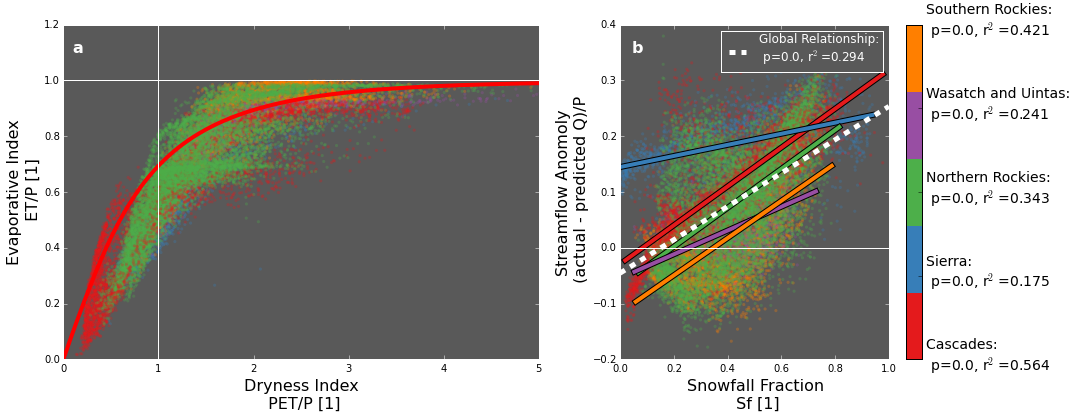

In [20]:
bgcolor = '0.35'

fig = plt.figure(figsize=(16, 6))
ax = plt.subplot2grid((1,13),(0,0), colspan = 7)
#ax.hexbin(data.PETpenvic_P,data.ET_P, gridsize=1)
ax.scatter(data.PETpenvic_P,data.ET_P,s = 10,c=data.rc, alpha=0.3, edgecolor='none', cmap=mpl.colors.ListedColormap(cbcust.mpl_colors))
ax.plot(DI,EI,'-r', lw=4)
ax.set_ylabel('Evaporative Index \n ET/P [1]',fontsize=16)
ax.set_xlabel('Dryness Index \n PET/P [1]', fontsize=16)
ax.axhline(1,c='w')
ax.axvline(1,c='w')
#ax.set_ylim(-0.2,1.2);
ax.set_xlim(0,5);
ax.set_ylim(0,1.2);
ax.set_axis_bgcolor(bgcolor)
#ax.axis('equal')
#ax.legend(['VIC Data','Budyko, 1974'], loc = 'lower right');
ax.annotate('a',[0.1,1.1], fontsize = 16, fontweight = 'bold', color='w');

ax2 = plt.subplot2grid((1,13),(0,8), colspan = 7)
#ax2.set_color_cycle(Set3_11.mpl_colors)
p1 = ax2.scatter(data.Sf,data.Qanom_P,s = 10, c = data.rc, alpha = 0.3, edgecolor = 'none', cmap=mpl.colors.ListedColormap(cbcust.mpl_colors));
cb=plt.colorbar(p1)
ct = 0
for Sf,mod in zip(Sfs,mods):
    ax2.plot(Sf,mod,'-', lw = 6, color = 'k')
    ax2.plot(Sf,mod,'-', lw = 4, color = cbcust.hex_colors[ct])
    ct += 1
p2 = ax2.plot(Sfg,modg,'--w', lw = 5)
ax2.set_xlabel('Snowfall Fraction \n Sf [1]', fontsize = 16);
ax2.set_ylabel('Streamflow Anomoly \n (actual - predicted Q)/P', fontsize=16)
ax2.annotate('b',[0.05,0.35], fontsize = 16, fontweight = 'bold',color='w');
ax2.set_axis_bgcolor(bgcolor)
ax2.axhline(0,c='w',lw=1)
ax2.set_xlim(0,1)
ax2.set_ylim(-.2,0.4)
#cb.set_label('Ecoregion')
cb.set_ticks(np.arange(1,6))
cb.set_ticklabels(names)
cb.set_alpha(1)
cb.draw_all()

leg = ax2.legend(p2,['Global Relationship: \n p='+str(round(gp_value,3))+', r$^2$='+str(round(gr_value**2,3))])
frame = leg.get_frame()
frame.set_facecolor(bgcolor)
frame.set_edgecolor('w')
text = leg.get_texts()
text[0].set_color('w')

for l in cb.ax.yaxis.get_ticklabels():
    l.set_fontsize(14)
    
for ax, color in zip([ax, ax2], ['w', 'w']):
    plt.setp(ax.spines.values(), color=color)
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=color)

#plt.savefig('./figures/fig1_reproduction_er_small.jpg')

#print 'r2 =',round(r_value**2,3)
#print 'p =',round(p_value,3)
#print 'slope =',round(slope,3)

***Figure 1 from Berghuijs et al.*** There is clear structure in A which cooresponds to different ecoregions. B shows the same relationship between Qanom and Sf as in Berghuijs et al.

## Plot different SF - Qanom relationships based on ecoregion

## Create a 4 panel plot of Sf vs Snowmelt and Qanom vs Snowmelt

Sf vs Qanom

Global p: 0.0 , Global r2: 0.294084697709

['Cascades: \n p=0.0, r$^2$=0.564', 'Sierra: \n p=0.0, r$^2$=0.175', 'Northern Rockies: \n p=0.0, r$^2$=0.343', 'Wasatch and Uintas: \n p=0.0, r$^2$=0.241']


snowmelt vs Sf

Global p: 0.0 , Global r2: 0.311967836477

['Cascades:\n p=0.0, r$^2$=0.441', 'Sierra:\n p=0.0, r$^2$=0.366', 'Northern Rockies:\n p=0.0, r$^2$=0.461', 'Wasatch and Uintas:\n p=0.0, r$^2$=0.62']


Snowmelt vs Qanom

Global p: 0.0 , Global r2: 0.320591067146

['Cascades:\n p=0.0, r$^2$=0.193', 'Sierra:\n p=0.0, r$^2$=0.407', 'Northern Rockies:\n p=0.0, r$^2$=0.319', 'Wasatch and Uintas:\n p=0.0, r$^2$=0.326']




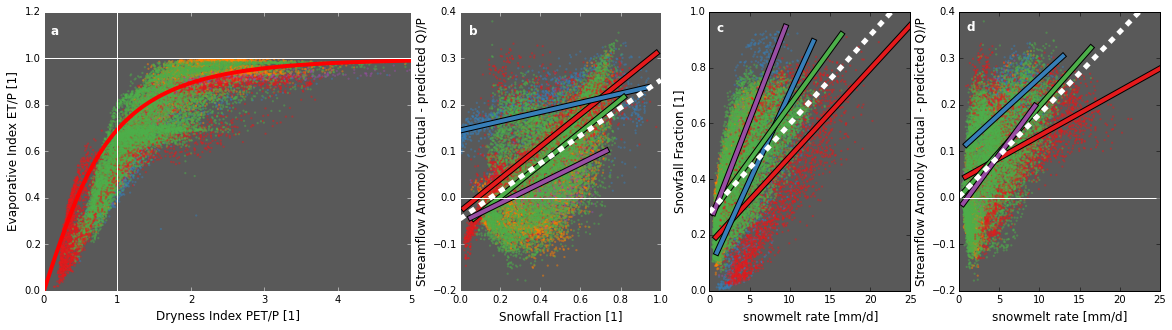

In [24]:
rowcol = (1,27)
figsize = (20,5)
s = 5
alpha = 0.5

fontsize = 12

fig = plt.figure(figsize=figsize)

ax1 = plt.subplot2grid(rowcol,(0,0), colspan = 9)
ax2 = plt.subplot2grid(rowcol,(0,10), colspan = 5)
ax3 = plt.subplot2grid(rowcol,(0,16), colspan = 5)
ax4 = plt.subplot2grid(rowcol,(0,22), colspan = 5)

# Budyko Curve and Sf Qanom 

X = data.Sf # pull out the independant variable
y = data.Qanom_P # pull out the dependant variable

slope, intercept, gr_value, gp_value, std_err = stats.linregress(X,y) # fit the model

Sfg = np.arange(0,1.001,.001) # generate a smooth snow fraction domain

modg = Sfg*slope+intercept # generate predicted values

mods = []
rvals = []
pvals = []
slopes = []
intercepts = []
Sfs = []

for rc in xrange(1,len(regions)):
    X = data.loc[data.rc==rc,'Sf'] # pull out the independant variable
    y = data.loc[data.rc==rc,'Qanom_P'] # pull out the dependant variable
    slope, intrccept, r_value, p_value, std_rcr = stats.linregress(X,y) # fit the model
    Sf = np.arange(data.loc[data.rc==rc,'Sf'].min(),data.loc[data.rc==rc,'Sf'].max()+0.001,0.001)
    mods.append(Sf*slope+intrccept) # genrcate predicted values
    rvals.append(r_value)
    pvals.append(p_value)
    slopes.append(slope)
    intercepts.append(intercept)
    Sfs.append(Sf)
    
names = []

rsqrds = np.square(rvals)

for er,p,r in zip(regions,pvals,rsqrds):
    
    names.append(er+': \n p='+str(round(p,4))+', r$^2$='+str(round(r,3)))

bgcolor = '0.35'

print 'Sf vs Qanom'
print
print 'Global p:',gp_value,', Global r2:',gr_value**2
print
print names
print
#print slopes
print

ax1.scatter(data.PETpenvic_P,data.ET_P,s = s,c=data.rc, alpha=alpha, edgecolor='none', cmap=mpl.colors.ListedColormap(cbcust.mpl_colors))
ax1.plot(DI,EI,'-r', lw=4)
ax1.set_ylabel('Evaporative Index ET/P [1]',fontsize=fontsize)
ax1.set_xlabel('Dryness Index PET/P [1]', fontsize=fontsize)
ax1.axhline(1,c='w')
ax1.axvline(1,c='w')
ax1.set_xlim(0,5);
ax1.set_ylim(0,1.2);
ax1.set_axis_bgcolor(bgcolor)
ax1.annotate('a',[0.1,1.1], fontsize = fontsize, fontweight = 'bold', color='w');

p1 = ax2.scatter(data.Sf,data.Qanom_P,s = s, c = data.rc, alpha = alpha, edgecolor = 'none', cmap=mpl.colors.ListedColormap(cbcust.mpl_colors));
ct = 0
for Sf,mod in zip(Sfs,mods):
    ax2.plot(Sf,mod,'-', lw = 6, color = 'k')
    ax2.plot(Sf,mod,'-', lw = 4, color = cbcust.hex_colors[ct])
    ct += 1
p2 = ax2.plot(Sfg,modg,'--w', lw = 5)
ax2.set_xlabel('Snowfall Fraction [1]', fontsize = fontsize);
ax2.set_ylabel('Streamflow Anomoly (actual - predicted Q)/P', fontsize=fontsize)
ax2.annotate('b',[0.05,0.35], fontsize = fontsize, fontweight = 'bold',color='w');
ax2.set_axis_bgcolor(bgcolor)
ax2.axhline(0,c='w',lw=1)
ax2.set_xlim(0,1)
ax2.set_ylim(-.2,0.4)

##########################

# Sf vs Snowmelt

X = data.snowmelt # pull out the independant variable
y = data.Sf # pull out the dependant variable

slope, intercept, gr_value, gp_value, std_err = stats.linregress(X,y) # fit the model

Sfg = np.arange(0,35.001,.001) # generate a smooth snow fraction domain

modg = Sfg*slope+intercept # generate predicted values


mods = []
rvals = []
pvals = []
slopes = []
intercepts = []
Sfs = []

Xname = 'snowmelt'
Yname = 'Sf'

for rc in xrange(1,len(regions)):
    X = data.loc[data.rc==rc,Xname] # pull out the independant variable
    y = data.loc[data.rc==rc,Yname] # pull out the dependant variable
    slope, intrccept, r_value, p_value, std_rcr = stats.linregress(X,y) # fit the model
    Sf = np.arange(data.loc[data.rc==rc,Xname].min(),data.loc[data.rc==rc,Xname].max()+0.001,0.001)
    mods.append(Sf*slope+intrccept) # genrcate predicted values
    rvals.append(r_value)
    pvals.append(p_value)
    slopes.append(slope)
    intercepts.append(intercept)
    Sfs.append(Sf)
names = []

rsqrds = np.square(rvals)

for er,p,r in zip(regions,pvals,rsqrds):
    
    names.append(er+':\n p='+str(round(p,4))+', r$^2$='+str(round(r,3)))


print 'snowmelt vs Sf'
print
print 'Global p:',gp_value,', Global r2:',gr_value**2
print
print names
print
#print slopes
print

p2 = ax3.scatter(data.snowmelt,data.Sf,s = s, c = data.rc, alpha = alpha, edgecolor = 'none', cmap=mpl.colors.ListedColormap(cbcust.mpl_colors));

ct = 0
for Sf,mod in zip(Sfs,mods):
    ax3.plot(Sf,mod,'-', lw = 6, color = 'k')
    ax3.plot(Sf,mod,'-', lw = 4, color = cbcust.hex_colors[ct])
    ct += 1
p2 = ax3.plot(Sfg,modg,'--w', lw = 5)
ax3.set_xlabel('snowmelt rate [mm/d]', fontsize = fontsize);
ax3.set_ylabel('Snowfall Fraction [1]', fontsize=fontsize)
ax3.annotate('c',[1,0.93], fontsize = fontsize, fontweight = 'bold',color='w');
ax3.set_axis_bgcolor(bgcolor)
ax3.axhline(0,c='w',lw=1)
ax3.set_xlim(0,25)
ax3.set_ylim(0,1)
    
## now Qanom vs Snowmelt

X = data.snowmelt # pull out the independant variable
y = data.Qanom_P # pull out the dependant variable

slope, intercept, gr_value, p_value, std_err = stats.linregress(X,y) # fit the model

Sfg = np.arange(0,35.001,.001) # generate a smooth snow fraction domain

modg = Sfg*slope+intercept # generate predicted values

mods = []
rvals = []
pvals = []
slopes = []
intercepts = []
Sfs = []

Xname = 'snowmelt'
Yname = 'Qanom_P'

for rc in xrange(1,len(regions)):
    X = data.loc[data.rc==rc,Xname] # pull out the independant variable
    y = data.loc[data.rc==rc,Yname] # pull out the dependant variable
    slope, intrccept, r_value, p_value, std_rcr = stats.linregress(X,y) # fit the model
    Sf = np.arange(data.loc[data.rc==rc,Xname].min(),data.loc[data.rc==rc,Xname].max()+0.001,0.001)
    mods.append(Sf*slope+intrccept) # genrcate predicted values
    rvals.append(r_value)
    pvals.append(p_value)
    slopes.append(slope)
    intercepts.append(intercept)
    Sfs.append(Sf)
names = []

rsqrds = np.square(rvals)

for er,p,r in zip(regions,pvals,rsqrds):
    
    names.append(er+':\n p='+str(round(p,4))+', r$^2$='+str(round(r,3)))
    
bgcolor = '0.35'

print 'Snowmelt vs Qanom'
print
print 'Global p:',gp_value,', Global r2:',gr_value**2
print
print names
print
#print slopes
print

p4 = ax4.scatter(data.snowmelt,data.Qanom_P,s = s, c = data.rc, alpha = alpha, edgecolor = 'none', cmap=mpl.colors.ListedColormap(cbcust.mpl_colors));
ct = 0
for Sf,mod in zip(Sfs,mods):
    ax4.plot(Sf,mod,'-', lw = 6, color = 'k')
    ax4.plot(Sf,mod,'-', lw = 4, color = cbcust.hex_colors[ct])
    ct += 1
p4 = ax4.plot(Sfg,modg,'--w', lw = 5)
ax4.set_xlabel('snowmelt rate [mm/d]', fontsize = fontsize);
ax4.set_ylabel('Streamflow Anomoly (actual - predicted Q)/P', fontsize=fontsize)
ax4.annotate('d',[1,0.36], fontsize = fontsize, fontweight = 'bold',color='w');
ax4.set_axis_bgcolor(bgcolor)
ax4.axhline(0,c='w',lw=1)
ax4.set_xlim(0,25)
ax4.set_ylim(-.2,.4)
    
for ax, color in zip([ax1, ax2, ax3, ax4], ['w', 'w']):
    plt.setp(ax.spines.values(), color=color)
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=color)
    
#plt.savefig('./figures/comment_4_pannel.png', bbox_inches='tight')